# Optimal velocity model with  a possible extension to a Multiple car-following model
This program simulates traffic flow using the optimal velocity  model (OVM) proposed by [Bando et al. (1995)](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.51.1035). Furthermore, it offers the possibility to extend the driving behaviour to a multiple car-following (MCF) model with a exponential weighting function based on the model of [Peng and Sun, 2010](https://www.sciencedirect.com/science/article/pii/S0375960110001805). The code offers the possibility to run parts of the simulation using a fortran module. This decreases substantially the integration time.

### Compile Fortran module
The computational expensive calculations can be done using the fortran module when the optimal velocity function (OVF) is set to `tanh`. The following cell compiles the fortran code in the file `f90_subroutines.f90` and builds the extension module ` f90_subroutines`.

In [ ]:
import os
os.system("f2py -c  f90_subroutines.f90 -m f90_subroutines")

256

### The functions.py file that wasn't imported

In [ ]:
class ovm(object):
    def __init__(self,parameters):
        """
        parameters of the model simulation are setup
        setup
        """
        self.update(parameters)

    def update(self,parameters):

        self.N =  parameters["N"]      # number of cars
        self.L =  parameters["L"]      # length of circuit
        self.distance = np.arange(0,self.L,1) #array for distance

        self.a =  parameters["a"]      # sensitiviy
        self.h =  parameters["h"]      #
        self.v0 = parameters["v0"] # maximum velocity

        self.m    = parameters["m"]  # number of cars in the interaction box (must be even number, if not is n=n-1)
        self.box  = parameters["box"] # box front, middle or back
        self.wf_name = parameters["weight_function"]
        self.wp = parameters["weight_parameter"]

        self.tmax  = parameters["tmax"] # maximum time
        self.dt    = parameters["dt"]     # time step
        self.iters = abs(int(self.tmax/self.dt))
        self.time  = np.arange(0,self.tmax,self.dt)

        self.xpert = parameters["xpert"] # position perturbation

        self.ovf = parameters["ovf"] # key for the choice of the OV-function
        self.acceleration_type = parameters["model"]
        self.lambda_v = parameters["lambda"]

        # allocate functions
        self.allocate_functions()

# =============================================================================
# Routines
# =============================================================================

    def allocate_functions(self):
        """
        allocate some functions
        """

        # optimal velocity function
        if self.ovf=="tanh":
            self.V=self.ovf_tanh
        if self.ovf=="hs":
            self.V=self.ovf_hs
        if self.ovf=="alg":
            self.V=self.ovf_alg

        # box of the considered platoon
        if self.box =="front":
            self.density = self.density_front
            self.flow_velocity = self.flow_velocity_front
        if self.box =="middle":
            self.density = self.density_middle
            self.flow_velocity = self.flow_velocity_middle
        if self.box =="back":
            self.density = self.density_back
            self.flow_velocity = self.flow_velocity_back

        # model type
        if self.acceleration_type == "OVM":
            self.acceleration = self.acceleration_OVM
        if self.acceleration_type == "MCF":
            self.acceleration = self.acceleration_MCF

        # weigthing function
        if self.wf_name == "exp":
            self.wf = self.exp_wf
        if self.wf_name == "lin":
            self.wf = self.lin_wf


    def initCars(self,**kwargs):
        """
        initialise 0th time step
        """

        self.b,self.c,self.f = self.steadyStateFlow(self.L,self.N)  # free flow variable

        self.x       = np.zeros(shape=(self.N,self.iters)) # position
        self.dot_x   = np.zeros(shape=(self.N,self.iters)) # velocity
        self.ddot_x  = np.zeros(shape=(self.N,self.iters)) # acceleration
        self.Delta_x = np.zeros(shape=(self.N,self.iters)) # headway
        self.local_rho = np.zeros(shape=(self.N,self.iters)) # local density
        self.local_flow = np.zeros(shape=(self.N,self.iters)) # local density
        self.local_q = np.zeros(shape=(self.N,self.iters)) # local flux-density


        self.x[:,0]      = np.arange(0,self.L,self.b)[:self.N] # make sure that array is not (accidentlly) to big
        self.dot_x[:,0]  = self.c

        self.ddot_x[:,0] = 0.

        self.x[:,0] = self.x[:,0] + self.xpert
        self.Delta_x[:,0]   = self.headway(self.x[:,0],self.L)
        self.local_rho[:,0] = self.density(self.x[:,0],self.Delta_x[:,0])
        self.local_flow[:,0] = self.flow_velocity(self.dot_x[:,0])



    def integrate(self,**kwargs):
        """
        Integrate the model using a fortran or a python kernel
        """

        if kwargs["kernel"]=="fortran":
            for i in range(0,self.iters-1):
                self.integration_procedure_f90(i)


        elif kwargs["kernel"]=="python":
            for i in range(0,self.iters-1):
                self.integration_procedure(i)

    def integration_procedure(self,i):
        """
        Runge-Kutta 4 integration scheme
        """
        h = self.dt
        k1 = self.acceleration(self.Delta_x[:,i],self.local_flow[:,i],self.local_rho[:,i],self.dot_x[:,i])
        self.dot_x[:,i+1] = self.dot_x[:,i] + k1*h/2

        k2 = self.acceleration(self.Delta_x[:,i],self.local_flow[:,i],self.local_rho[:,i],self.dot_x[:,i+1])

        self.dot_x[:,i+1] = self.dot_x[:,i] + k2*h/2
        k3 = self.acceleration(self.Delta_x[:,i],self.local_flow[:,i],self.local_rho[:,i],self.dot_x[:,i+1])

        self.dot_x[:,i+1] = self.dot_x[:,i] + k3*h
        k4 = self.acceleration(self.Delta_x[:,i],self.local_flow[:,i],self.local_rho[:,i],self.dot_x[:,i+1])

        self.ddot_x[:,i+1] = k1

        self.dot_x[:,i+1] = self.dot_x[:,i] + h/6. * (k1 + 2*k2 + 2*k3 + k4)

        self.x[:,i+1]      = self.x[:,i] + self.dot_x[:,i+1] * h

        self.x[:,i+1]      = self.x[:,i+1]%self.L

        # Diagnostics
        self.Delta_x[:,i+1]   = self.headway(self.x[:,i+1],self.L)
        self.local_rho[:,i+1] = self.density(self.x[:,i+1],self.Delta_x[:,i+1])
        self.local_flow[:,i+1] = self.flow_velocity(self.dot_x[:,i+1])
        self.local_q[:,i+1] = self.local_rho[:,i+1] * self.local_flow[:,i+1]


    def integration_procedure_f90(self,i):
        """
        using a rk4 scheme from a fortran code
        """
        self.dot_x[:,i+1],self.x[:,i+1],self.Delta_x[:,i+1],self.local_rho[:,i+1],self.local_flow[:,i+1] = \
                ovmf90.rk4(self.a,self.lambda_v,self.v0,self.h,self.L,self.N,self.m,self.wp, \
                           self.local_rho[:,i],self.local_flow[:,i],self.x[:,i],self.dot_x[:,i],self.dt)

# =============================================================================
# Functions
# =============================================================================
    def acceleration_MCF(self,Delta_x,local_flow,local_rho,dot_x):
        """
        returns the accelaration of a car as relaxation to local flow
        """
        # using pyhton
        ddotx = self.a*(self.V(1/local_rho) - dot_x) + self.lambda_v * (local_flow - dot_x)
        return ddotx

    def acceleration_OVM(self,Delta_x,local_flow,local_rho,dot_x):
        """
        returns the accelaration of a car as function of Delta x
        """
        return self.a*(self.V(Delta_x) - dot_x)


    def headway(self,x,L):
        Dx = np.zeros(self.N)
        Dx[:-1] = ((x[1:] - x[:-1])+L)%L
        Dx[-1] = ((x[0] - x[-1])+L)%L
        return Dx #(np.roll(x,-1)-x+L)%L

    def ovf_tanh(self,Delta_x):
        """
        OV - function as in Bando et al (1995)
        Legal velocity - V(Delta_x)
        Delta_x - headway to the car in front
        """

        return self.v0*(np.tanh(Delta_x - self.h) + np.tanh(self.h))

    def ovf_hs(self,Delta_x):
        """
        OV - function as in Sugiyama and Yamada (1997)
        Legal velocity - V(Delta_x)
        Delta_x - headway to the car in front
        """
        return self.v0*(np.heaviside(Delta_x - self.h,1))

    def ovf_alg(self,Delta_x):
        """
        OV - function as in Orosz (2005)
        Legal velocity - V(Delta_x)
        Delta_x - headway to the car in front
        """
        ovf_return = np.zeros(self.N)
        ovf_return[:] = self.v0*np.divide(np.power(Delta_x - 1,3),1+np.power(Delta_x - 1,3))

        index = np.where(Delta_x<=1)
        ovf_return[index] = 0

        return ovf_return

    def steadyStateFlow(self,L,N):
        """
        Returns parameters b, c and f of  a steady state flow.
        Input:
            L - length of circuit
            N - number of cars
        Returns:
            b - constant spacing
            c - constant velocity
            f - derivative V(b)
        """
        b = float(L)/float(N)
        c = self.V(b)
        f = 1 - np.tanh(b)**2
        return b,c,f

    def density_front(self,x,Dx):
        """
        compute the local density for each car
        x is unused but can't be excluded because self.density(x,Dx) needs to have x and Dx
        as argument for density back and middle

        the function returns the weighted avergage of Dx times the number of cars

        old box size: box_size_old = (np.roll(x,-car_number) -x)%self.L
        """
        car_number = int(self.m)
        # extend array for periodic boundary
        Dx_extended = np.append(Dx,Dx[:car_number-1])

        # prepare weights so that weighting can be done by a convolution
        v_values = self.wf(np.arange(car_number))

        # weightes
        v = v_values/sum(v_values)*car_number

        # apply convolution of headways with weights
        box_size = (np.convolve(Dx_extended, v, mode='valid'))#%self.L with the modulo this leads to results as if box_size_old is used

        # compute local front rho
        rho = float(car_number)/box_size
        return rho

    def density_middle(self,x,Dx):
        """
        compute the local density for each car
        """
        car_number = int(self.m/2)
        # density middle

        box_size = (np.roll(x,-car_number) -x)%self.L + (x -np.roll(x,car_number))%self.L
        rho = 2*float(car_number)/box_size
        return rho

    def density_back(self,x,Dx):
        """
        compute the local density for each car
        """
        car_number = int(self.m)
        #density back
        box_size = (x -np.roll(x,car_number))%self.L
        rho = float(car_number)/box_size
        return rho

    def flow_velocity_front(self,dotx):
        """
        compute the local flow velocity for each car using moving averages with
        periodic boundary conditions
        """
        # flow velocity front
        car_number = int(self.m)
        dotx_extended = np.append(dotx,dotx[:car_number-1])

        a = dotx_extended

        v_function = self.wf(np.arange(car_number))

        v = v_function/sum(v_function)

        dotx_flow = np.convolve(a, v, mode='valid')
        dotx_flow = np.roll(dotx_flow,-1)
        return dotx_flow

    def flow_velocity_middle(self,dotx):
        """
        compute the local flow velocity for each car using moving averages with
        periodic boundary conditions
        """
        # flow velocity middle
        car_number = int(self.m/2)
        dotx_extended = np.append(dotx[-car_number:],dotx)
        dotx_extended = np.append(dotx_extended,dotx[:car_number])
        dotx_flow = np.convolve(dotx_extended, np.ones((2*car_number+1,))/(2*car_number+1), mode='valid')
        return dotx_flow

    def flow_velocity_back(self,dotx):
        """
        compute the local flow velocity for each car using moving averages with
        periodic boundary conditions
        """
        #flow velocity back
        car_number = int(self.m)
        dotx_extended = np.append(dotx[-car_number:],dotx)
        dotx_flow = np.convolve(dotx_extended, np.ones((car_number+1,))/(car_number+1), mode='valid')
        return dotx_flow

    def exp_wf(self,argument):
        return np.exp(self.wp*argument)

    def lin_wf(self,argument):
        return self.wp*argument + 1

### Import necessary python modules
The following cell imports necessary modules. The module `functions` contains all functions and routines for the integration of the model. In the module `plot` some pre-designed plots are defined.

In [ ]:
# import own pyhton modules
#import functions as fc
#import plot as plot

# import other modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import time
import gc

### Set parameters for the model

Before the model can be run, some parameters have to be set. These parameters determine for instance the chosen model that can be the OVM or the MCF model. [Bando et al. (1995)](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.51.1035) defined the optimal velocity function (OVF) as:

$V(\Delta x) = v_\mathrm{0}(\tanh(\Delta x - h) + \tanh h)$


This function is the `tanh`-function. Besides the `tanh`-function, one can chose a Heaviside function  (key: `hs`) as in [Sugiyama and Yamada (1997)](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.55.7749) or an algebraic function (key: `alg`) as in [Orosz et al. (2005)](https://www.sciencedirect.com/science/article/pii/S0167278905003775) for the OVF function. All parameters are summerized in the table below:



parameter | type      | value       | description
----------|-----------|-------------|--------------
model     | `str`     | OVM, MCF    | chosen model
N         | `int`     | e.g. 100    | number of cars
L         | `float`   | e.g. 200.0   | circuit length
a         | `float`   | e.g. 1.0     | sensitivity
ovf       | `str`     | tanh, hs, alg | optimal velocity function (OVF)
h         | `float`   | e.g. 2.0     | parameter in the tanh-OVF (inflection point)
v0        | `float`   | e.g. 1.0     | velocity scale
box       |`str`      | front, middle, back| platoon of cars that is considered
m         | `int`     | 5           | number of cars in the platoon
weight_function | `str` | exp, lin | weight function
weight_parameter| `float` | e.g 0.5 | exponent for exponential or coefficent for linear weigthing
lambda      | `float`     | e.g. 0.1 | relaxation strength
tmax        | `float`     | e.g. 1000.0| integration time
dt          | `float`     | e.g. 0.1   | time step
xpert       | `float`     | ndarray of size N| perturbation to the inital position of a car  

In [ ]:
parameters = {
        "model":"OVM",
        "N":100,
        "L":242,
        "a":1.,
        "h":2.,
        "v0":5.,
        "ovf":"tanh",
        "m": 1,
        "box":"front",
        "weight_function":"exp",
        "weight_parameter":0.5,
        "lambda": 0.0,
        "tmax":1000,
        "dt" : 0.1
        }

parameters["xpert"] = np.zeros(parameters["N"])
parameters["xpert"][0] = 0.1

### Model simulation

In the following cell the actual integration takes place. A model instance is generate based on the chosen parameter setting. Then, the cars are initialized around the steady state free flow with the a perturbation defined by the array `xpert` in the parameter settings:

$\Delta x_i = \frac{L}{N} + x_{pert,i} \text{ for all } i \in \{1,...,N\}$

$\dot{x}_i = V(\Delta x_i)$

After this the model is integrated using either a `python` or a `fortran` routine (defined through the option `kernel`).

In [ ]:
#starting time
t_start = time.time()

# generate a model instance from the chosen parameter setting
model = ovm(parameters)

# initialize the cars in the model with a perturbation to the steady free flow
model.initCars()

# integrate the model using python or fortran (note that if kernel is fortran model automatically is a MCF-model)
model.integrate(kernel="python")

#ending  time
t_end = time.time()

print("Integration time:" + str(t_end-t_start))

Integration time:2.4118576049804688


## Plot results

Plot the results in a panal plot. The function `ovm_small_panal` plots a 2x3 panal with various variables and the function `ovm_panal` a 3x4 panal. The plots are defined in the file `plot.py`.

#### Plot Helper functions

In [ ]:
from scipy.interpolate import griddata
from sklearn.neighbors import KernelDensity

fs = 14

def ovm_panal(ovm):
    """
    This function plots a 3x4 panal with a different plots
    """
    x = ovm.x
    dot_x = ovm.dot_x
    Delta_x = ovm.Delta_x
    local_rho = ovm.local_rho
    local_flow = ovm.local_flow
    local_q = ovm.local_q

    time = ovm.time
    distance = ovm.distance

    # =============================================================================
    # plot
    # =============================================================================
    plt.close("all")

    # plot the hovmöller plots
    hov = True
    # =============================================================================
    # Panal
    # =============================================================================
    fig, ax = plt.subplots(3,4)
    fig.subplots_adjust(hspace=0.53, wspace=0.3)
    fig.set_size_inches(12, 6)

    # posistions
    jump_car = 1 # just plot line of every 8th car

    for j in np.arange(0,ovm.N,jump_car):
        diffx = np.roll(x[j,:],-1)-x[j,:]
        masked_x = np.ma.array(x[j,:])
        masked_x[diffx<0] = np.ma.masked
        ax[0,0].plot(time,masked_x,lw=0.2,c="k")
    ax[0,0].set_title("car positions")
    ax[0,0].set_ylabel("position")
    ax[0,0].set_xlabel("time")
    ax[0,0].set_ylim(0,ovm.L)
    ax[0,0].set_xlim(0,ovm.tmax)


    # velocities vs. car number
    start = 1 # int(ovm.iters/10)
    end   = int(ovm.iters-1)

    ax[0,2].plot(dot_x[:,start],label="t="+str(int(ovm.time[start])))
    ax[0,2].plot(dot_x[:,end],label="t="+str(int(ovm.time[end-1])))
    ax[0,2].set_title("velocity vs. car")
    ax[0,2].set_xlabel("car number")
    ax[0,2].set_ylabel("velocity")
    ax[0,2].set_xlim(0,ovm.N)
    ax[0,2].set_ylim(0,2.*ovm.v0)
    ax[0,2].legend()

    # phase space headway velocity
    car =  0
    start = 0
    end   = ovm.iters
    iters = end - start
    jump = 3  # just plot every 3rd iteration to save time

    c = np.linspace(ovm.time[start],ovm.time[end-1],iters)

    ax[0,3].set_title("velocity vs. headway, car=" + str(car))
    ax_scatter = ax[0,3].scatter(Delta_x[car,start:end:jump],dot_x[car,start:end:jump],marker="x",s=10,c=c[::jump])
    ax[0,3].set_xlabel("headway")
    ax[0,3].set_ylabel("velocity")
    ax[0,3].set_ylim(0,2*ovm.v0)
    ax[0,3].set_xlim(0,5)
    fig.colorbar(ax_scatter, ax=ax[0,3],label="time")


    # velocity hovmöller
    if hov:
        jump = 100  # just consider every 100 iteration for the interpolation to save time
        x_data = x[:,::jump]
        dot_x_data = dot_x[:,::jump]
        t_data = time[::jump]
        lent = len(t_data)

        grid_x, grid_t = np.meshgrid(distance,time)
        x_point =  x_data.reshape(ovm.N*lent,1)
        t_point =  np.tile(t_data,ovm.N)
        t_point =  t_point.reshape(ovm.N*lent,1)
        points = np.concatenate((x_point,t_point),axis=1)
        dot_x_values = dot_x_data.reshape(ovm.N*lent)
        grid_dot_x = griddata(points, dot_x_values, (grid_x, grid_t), method='linear')

        cmap = "inferno"
        contours = np.arange(0,2*ovm.v0+0.1,.1)
        cf = ax[1,0].contourf(time,distance,grid_dot_x.T,contours,cmap=cmap)
        ax[1,0].set_xlabel("time")
        ax[1,0].set_ylabel("position")
        ax[1,0].set_title("velocity")
        fig.colorbar(cf, ax=ax[1,0],label="velocity")


    # density hovmöller
    if hov:
        jump = 100  # just consider every 100 iteration for the interpolation to save time
        x_data = x[:,::jump]
        rho_data = local_rho[:,::jump]
        t_data = time[::jump]
        lent = len(t_data)

        grid_x, grid_t = np.meshgrid(distance,time)
        x_point =  x_data.reshape(ovm.N*lent,1)
        t_point =  np.tile(t_data,ovm.N)
        t_point =  t_point.reshape(ovm.N*lent,1)
        points = np.concatenate((x_point,t_point),axis=1)
        rho_values = rho_data.reshape(ovm.N*lent)
        grid_rho = griddata(points, rho_values, (grid_x, grid_t), method='linear')

        cmap = "viridis"
        contours = np.arange(0,3.1,.1)
        cf = ax[2,1].contourf(time,distance,grid_rho.T,contours,cmap=cmap)
        ax[2,1].set_xlabel("time")
        ax[2,1].set_ylabel("position")
        ax[2,1].set_title("local density")
        fig.colorbar(cf, ax=ax[2,1],label=r"$\rho$")

    # flow velocity hovmöller
    if hov:
        jump = 100  # just consider every 100 iteration for the interpolation to save time
        x_data = x[:,::jump]
        flow_data = local_flow[:,::jump]
        t_data = time[::jump]
        lent = len(t_data)

        grid_x, grid_t = np.meshgrid(distance,time)
        x_point =  x_data.reshape(ovm.N*lent,1)
        t_point =  np.tile(t_data,ovm.N)
        t_point =  t_point.reshape(ovm.N*lent,1)
        points = np.concatenate((x_point,t_point),axis=1)
        flow_values = flow_data.reshape(ovm.N*lent)
        grid_flow = griddata(points, flow_values, (grid_x, grid_t), method='linear')

        cmap = "inferno"
        contours = np.arange(0,2*ovm.v0+0.1,.1)
        cf = ax[2,0].contourf(time,distance,grid_flow.T,contours,cmap=cmap)
        ax[2,0].set_xlabel("time")
        ax[2,0].set_ylabel("position")
        ax[2,0].set_title("local flow velocity")
        fig.colorbar(cf, ax=ax[2,0],label=r"flow velocity")

    # flux density hovmöller
    if hov:
        jump = 100  # just consider every 100 iteration for the interpolation to save time
        x_data = x[:,::jump]
        var_data = local_q[:,::jump]
        t_data = time[::jump]
        lent = len(t_data)

        grid_x, grid_t = np.meshgrid(distance,time)
        x_point =  x_data.reshape(ovm.N*lent,1)
        t_point =  np.tile(t_data,ovm.N)
        t_point =  t_point.reshape(ovm.N*lent,1)
        points = np.concatenate((x_point,t_point),axis=1)
        var_values = var_data.reshape(ovm.N*lent)
        grided_var = griddata(points, var_values, (grid_x, grid_t), method='linear')

        cmap = "rainbow"
        contours = np.arange(0.2,0.6,.02)
        cf = ax[2,2].contourf(time,distance,grided_var.T,contours,cmap=cmap,extend="both")
        ax[2,2].set_xlabel("time")
        ax[2,2].set_ylabel("position")
        ax[2,2].set_title("local flux density velocity")
        fig.colorbar(cf, ax=ax[2,2],label=r"flux density")

    # fundamental diagram all
    car =  0
    start = 0
    end   = ovm.iters
    iters = end - start
    jump = 3  # just plot every 3rd iteration to save time



    c = dot_x[:,start:end:jump].ravel()
    x = local_rho[:,start:end:jump].ravel()
    y = local_q[:,start:end:jump].ravel()

    rho_ideal = np.linspace(0.01,5,100)
    q_ideal  = rho_ideal * ovm.V(1/rho_ideal)

    ax[2,3].set_title("fundamental diagramm")
    ax_scatter = ax[2,3].scatter(x,y,marker=".",s=10,c=c,cmap="inferno")
    ax[2,3].set_xlabel("density")
    ax[2,3].set_ylabel("flux density")
    ax[2,3].set_xlim(0,2)
    ax[2,3].set_ylim(0,1.1*max(y))
    fig.colorbar(ax_scatter, ax=ax[2,3],label="velocity")

    ax[2,3].plot(rho_ideal,q_ideal)

    # fundamental diagram one car
    car =  0
    start = int(0.8*ovm.iters)
    end   = ovm.iters
    iters = end - start
    jump = 3  # just plot every 3rd iteration to save time

    c = np.linspace(ovm.time[start],ovm.time[end-1],iters)
    x = local_rho[car,start:end:jump]
    y = local_q[car,start:end:jump]

    rho_ideal = np.linspace(0.01,5,100)
    q_ideal  = rho_ideal * ovm.V(1/rho_ideal)

    ax[1,3].set_title("fundamental diagramm")
    ax_scatter = ax[1,3].scatter(x,y,marker="x",s=10,c=c[::jump],cmap="viridis")
    ax[1,3].set_xlabel("density")
    ax[1,3].set_ylabel("flux density")
    ax[1,3].set_xlim(0,2)
    ax[1,3].set_ylim(0,1.1*max(y))
    fig.colorbar(ax_scatter, ax=ax[1,3],label="time")
    ax[1,3].plot(rho_ideal,q_ideal)


    #std_deviation
    ax[1,1].set_title("std($\Delta$x) vs. t")
    ax[1,1].plot(time,Delta_x.std(axis=0))
    ax[1,1].set_xlabel("time")
    ax[1,1].set_ylabel("std")

    #kernel densitiy
    dot_x_plot = np.linspace(0, 2, 1000)[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(dot_x[:,-1][:, np.newaxis])
    log_dens = kde.score_samples(dot_x_plot)

    ax[1,2].plot(dot_x_plot[:, 0], np.exp(log_dens))
    ax[1,2].set_title("KDE of velocities")
    ax[1,2].set_ylabel("Normalized Density")
    ax[1,2].set_xlabel("velocity")

    #kernel densitiy
    dot_x_plot = np.linspace(0, 2, 1000)[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(dot_x[:,-1][:, np.newaxis])
    log_dens = kde.score_samples(dot_x_plot)

    ax[1,2].plot(dot_x_plot[:, 0], np.exp(log_dens))
    ax[1,2].set_title("KDE of velocities")
    ax[1,2].set_ylabel("Normalized Density")
    ax[1,2].set_xlabel("velocity")


def ovm_small_panal(ovm):
    """
    This function plots a 2x3 panal with a different plots
    """
    x = ovm.x
    dot_x = ovm.dot_x
    Delta_x = ovm.Delta_x
    local_rho = ovm.local_rho

    time = ovm.time
    distance = ovm.distance

    # =============================================================================
    # plot
    # =============================================================================

    # plot the hovmöller plots (save time for for quicklook if set false)
    hov = True
    # =============================================================================
    # Panal
    # =============================================================================
    fig, ax = plt.subplots(2,3)
    fig.subplots_adjust(hspace=0.53, wspace=0.3)
    fig.set_size_inches(12, 6)

    # posistions
    jump_car = 1 # just plot line of every 8th car

    for j in np.arange(0,ovm.N,jump_car):
        diffx = np.roll(x[j,:],-1)-x[j,:]
        masked_x = np.ma.array(x[j,:])
        masked_x[diffx<0] = np.ma.masked
        ax[0,0].plot(time,masked_x,lw=0.2,c="k")
    ax[0,0].set_title("car positions")
    ax[0,0].set_ylabel("position")
    ax[0,0].set_xlabel("time")
    ax[0,0].set_ylim(0,ovm.L)
    ax[0,0].set_xlim(0,ovm.tmax)


    # velocities vs. car number
    start = 1 # int(ovm.iters/10)
    end   = int(ovm.iters-1)

    ax[0,1].plot(dot_x[:,start],label="t="+str(int(ovm.time[start])))
    ax[0,1].plot(dot_x[:,end],label="t="+str(int(ovm.time[end-1])))
    ax[0,1].set_title("velocity vs. car")
    ax[0,1].set_xlabel("car number")
    ax[0,1].set_ylabel("velocity")
    ax[0,1].set_xlim(0,ovm.N)
    ax[0,1].set_ylim(0,2*ovm.v0)
    ax[0,1].legend()

    # phase space headway velocity
    car =  0
    start = 0
    end   = ovm.iters
    iters = end - start
    jump = 3  # just plot every 3rd iteration to save time

    c = np.linspace(ovm.time[start],ovm.time[end-1],iters)

    ax[0,2].set_title("velocity vs. headway, car=" + str(car))
    ax_scatter = ax[0,2].scatter(Delta_x[car,start:end:jump],dot_x[car,start:end:jump],marker="x",s=10,c=c[::jump])
    ax[0,2].set_xlabel("headway")
    ax[0,2].set_ylabel("velocity")
    ax[0,2].set_ylim(0,2.*ovm.v0)
    ax[0,2].set_xlim(0,5)
    fig.colorbar(ax_scatter, ax=ax[0,2],label="time")


    # velocity hovmöller
    if hov:
        jump = int(ovm.tmax/100)  # just consider every 100 iteration for the interpolation to save time
        x_data = x[:,::jump]
        dot_x_data = dot_x[:,::jump]
        t_data = time[::jump]
        lent = len(t_data)

        grid_x, grid_t = np.meshgrid(distance,time)
        x_point =  x_data.reshape(ovm.N*lent,1)
        t_point =  np.tile(t_data,ovm.N)
        t_point =  t_point.reshape(ovm.N*lent,1)
        points = np.concatenate((x_point,t_point),axis=1)
        dot_x_values = dot_x_data.reshape(ovm.N*lent)
        grid_dot_x = griddata(points, dot_x_values, (grid_x, grid_t), method='linear')

        cmap = "inferno"
        contours = np.linspace(0,2*ovm.v0+0.1,20)
        cf = ax[1,0].contourf(time,distance,grid_dot_x.T,contours,cmap=cmap)
        ax[1,0].set_xlabel("time")
        ax[1,0].set_ylabel("position")
        ax[1,0].set_title("velocity")
        fig.colorbar(cf, ax=ax[1,0],label="velocity")


    # density hovmöller
    if hov:
        jump = int(ovm.tmax/100)  # just consider every 100 iteration for the interpolation to save time
        x_data = x[:,::jump]
        rho_data = local_rho[:,::jump]
        t_data = time[::jump]
        lent = len(t_data)

        grid_x, grid_t = np.meshgrid(distance,time)
        x_point =  x_data.reshape(ovm.N*lent,1)
        t_point =  np.tile(t_data,ovm.N)
        t_point =  t_point.reshape(ovm.N*lent,1)
        points = np.concatenate((x_point,t_point),axis=1)
        rho_values = rho_data.reshape(ovm.N*lent)
        grid_rho = griddata(points, rho_values, (grid_x, grid_t), method='linear')

        cmap = "viridis"
        contours = np.arange(0,3.1,.1)
        cf = ax[1,1].contourf(time,distance,grid_rho.T,contours,cmap=cmap)
        ax[1,1].set_xlabel("time")
        ax[1,1].set_ylabel("position")
        ax[1,1].set_title("local density")
        fig.colorbar(cf, ax=ax[1,1],label=r"$\rho$")

    #std_deviation
    ax[1,2].set_title("std($\Delta$x) vs. t")
    ax[1,2].plot(time,Delta_x.std(axis=0))
    ax[1,2].set_xlabel("time")
    ax[1,2].set_ylabel("std")

#### Results

66053

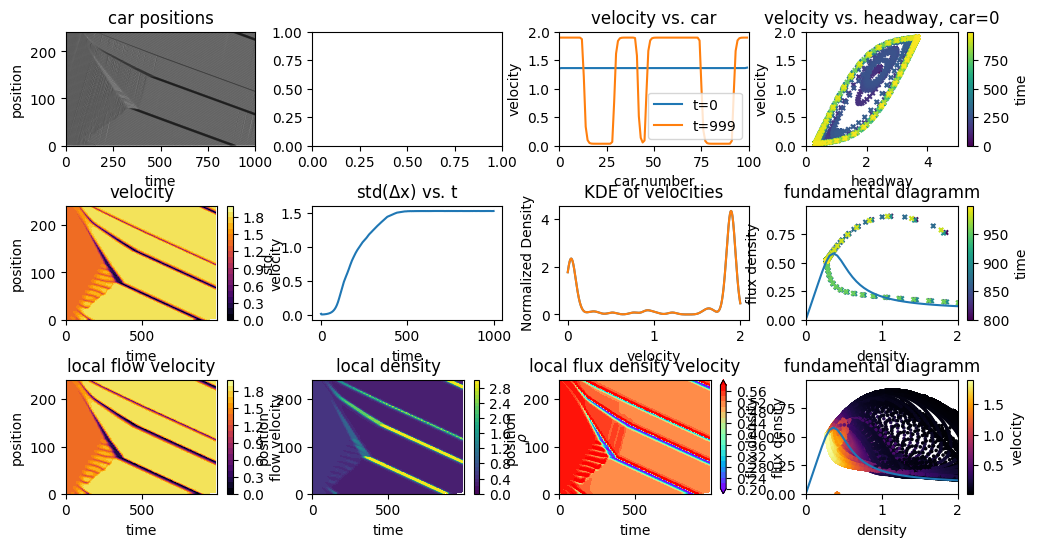

In [ ]:
plt.close("all")

# generate a panal plot
ovm_panal(model)

# release unreferenced memory
gc.collect()

### Parameter Calibration

In [ ]:
import pandas as pd

# Replace 'ChennaiTrajectoryData2.45-3.00PM.xlsx' with the actual file name
file_name = 'ChennaiTrajectoryData2.45-3.00PM.xlsx'

# Load the Excel file into a DataFrame
df = pd.read_excel(file_name)

# Display the first few rows of the DataFrame
df.head()

,Vehicle Number,Vehicle Type,Time (sec),Length (m),Width (m),Long Distance (m),Long Speed (m/sec),Long Acc (m/sec2),Lat Distance (m),Lat Speed (m/sec),Lat Acc (m/sec2),Flag
0,1,1,3.0,1.8,0.6,21.824918,4.874649,-0.722183,2.351874,-0.009967,-0.105182,0
1,1,1,3.5,1.8,0.6,25.926373,4.243077,0.308803,2.292952,-0.062771,0.014188,0
2,1,1,4.0,1.8,0.6,30.411296,5.319463,1.023511,2.206669,0.037657,0.238653,0
3,1,1,4.5,1.8,0.6,35.699721,6.575488,2.213050,2.407390,0.141523,-0.147137,0
4,1,1,5.0,1.8,0.6,43.430696,7.267821,-1.793718,2.438842,-0.099596,-0.240332,0


In [ ]:
unique_vehicle_numbers = df['Vehicle Number'].nunique()
print("Number of unique vehicle numbers:", unique_vehicle_numbers)

Number of unique vehicle numbers: 1514


In [ ]:
import numpy as np

def calculate_mse(arr1, arr2):
    # Initialize an empty list to store squared differences
    squared_diffs = []

    # Iterate through subarrays of both input arrays
    for subarr1, subarr2 in zip(arr1, arr2):
        # Find the length of the shorter subarray
        min_length = min(len(subarr1), len(subarr2))

        # Calculate squared differences for the common elements
        squared_diff = [(x - y) ** 2 for x, y in zip(subarr1[:min_length], subarr2[:min_length])]

        # If one subarray is longer, add squared differences for the remaining elements
        if len(subarr1) > len(subarr2):
            squared_diff.extend([(x - 0) ** 2 for x in subarr1[min_length:]])
        elif len(subarr2) > len(subarr1):
            squared_diff.extend([(0 - y) ** 2 for y in subarr2[min_length:]])

        # Append the squared differences to the list
        squared_diffs.append(squared_diff)

    # Calculate the mean squared error
    mse = np.mean(squared_diffs)

    return mse

In [ ]:
long_speeds_per_vehicle_array.shape

(1514,)

In [ ]:
def objective_function(params, observed_long_speeds, model):
    # Set the OVM parameters
    parameters = {
            "model":"OVM",
            "N":1514,
            "L":242,
            "a": params[0],
            "h": params[1],
            "v0":params[2],
            "ovf":"tanh",
            "m": 1,
            "box":"front",
            "weight_function":"exp",
            "weight_parameter":0.5,
            "lambda": 0.0,
            "tmax":1000,
            "dt" : 0.1
            }

    parameters["xpert"] = np.zeros(parameters["N"])
    parameters["xpert"][0] = 0.1

    model = ovm(parameters)

    # Initialize the cars in the model
    model.initCars()

    # Integrate the model
    model.integrate(kernel="python")

    # Get the model's predicted long speeds
    model_long_speeds = model.dot_x

    # Calculate the Mean Squared Error (MSE) between observed and model long speeds
    mse = calculate_mse(model_long_speeds, observed_long_speeds)

    return mse

In [ ]:
grouped = df.groupby("Vehicle Number")["Long Speed (m/sec)"].apply(list)

# Convert the grouped data to a list of arrays
long_speeds_per_vehicle = grouped.tolist()

long_speeds_per_vehicle_array = np.array([np.array(x) for x in long_speeds_per_vehicle], dtype=object)

In [ ]:
from scipy.optimize import minimize

# Define your observed long speeds (replace this with your actual data)
observed_long_speeds = long_speeds_per_vehicle_array

# Define an initial guess for the parameters a, h, and v0
initial_parameters = np.array([1.0, 2.0, 5.0])

# Create an OVM model instance (replace this with your actual model initialization)

parameters = {
        "model":"OVM",
        "N":1514,
        "L":242,
        "a": initial_parameters[0],
        "h": initial_parameters[1],
        "v0":initial_parameters[2],
        "ovf":"tanh",
        "m": 1,
        "box":"front",
        "weight_function":"exp",
        "weight_parameter":0.5,
        "lambda": 0.0,
        "tmax":100,
        "dt" : 1
        }

parameters["xpert"] = np.zeros(parameters["N"])
parameters["xpert"][0] = 0.1

model = ovm(parameters)

# Define bounds for the parameters (if needed)
parameter_bounds = [(0.1, 10.0), (0.1, 10.0), (1.0, 50.0)]

# Run the optimization
result = minimize(objective_function, initial_parameters, args=(observed_long_speeds, model),
                  bounds=parameter_bounds, method='L-BFGS-B')

# Extract the calibrated parameters
calibrated_parameters = result.x

# Print the calibrated parameters
print("Calibrated Parameters:")
print("a:", calibrated_parameters[0])
print("h:", calibrated_parameters[1])
print("v0:", calibrated_parameters[2])


Calibrated Parameters:
a: 1.0000066361904183
h: 2.546854555437534
v0: 4.944369155080379


In [ ]:
params = np.array([3.0, 12.0, 25.0])

parameters = {
        "model":"OVM",
        "N":1514,
        "L":242,
        "a": params[0],
        "h": params[1],
        "v0":params[2],
        "ovf":"tanh",
        "m": 1,
        "box":"front",
        "weight_function":"exp",
        "weight_parameter":0.5,
        "lambda": 0.0,
        "tmax":100,
        "dt" : 1
        }

parameters["xpert"] = np.zeros(parameters["N"])
parameters["xpert"][0] = 0.1

model = ovm(parameters)

# Define bounds for the parameters (if needed)
parameter_bounds = [(0.1, 10.0), (0.1, 10.0), (1.0, 50.0)]

objective_function(params, long_speeds_per_vehicle_array, model)

In [ ]:
params = np.array([1.0, 2.5469, 4.9444])

parameters = {
        "model":"OVM",
        "N":1514,
        "L":242,
        "a": params[0],
        "h": params[1],
        "v0":params[2],
        "ovf":"tanh",
        "m": 1,
        "box":"front",
        "weight_function":"exp",
        "weight_parameter":1,
        "lambda": 0.0,
        "tmax":100,
        "dt" : 1
        }

parameters["xpert"] = np.zeros(parameters["N"])
parameters["xpert"][0] = 0.1

model = ovm(parameters)

In [ ]:
model = ovm(parameters)

model.initCars()

    # Integrate the model
model.integrate(kernel="python")

    # Get the model's predicted long speeds
model_long_speeds = model.dot_x

In [ ]:
model_long_speeds.shape

(1514, 10000)

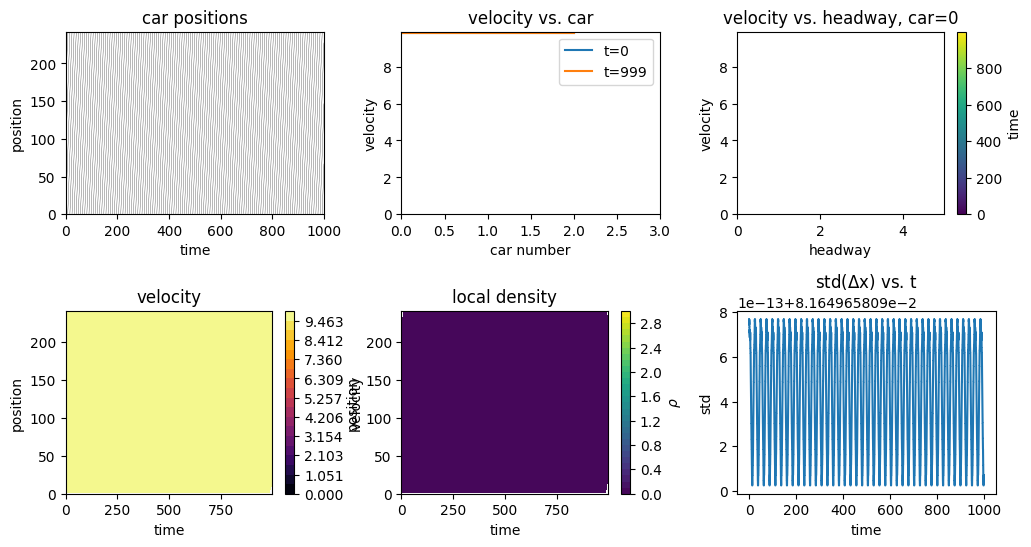

In [ ]:
ovm_small_panal(model)

### Testing

In [ ]:
file_name = '/content/ChennaiTrajectoryData3.00-3.15PM.xlsx'

# Load the Excel file into a DataFrame
test = pd.read_excel(file_name)

# Display the first few rows of the DataFrame
test.head()

,Vehicle Number,Vehicle Type,Time (sec),Length,Width,Long Distance (m),Long Speed (m/sec),Long Acc (m/sec2),Lat Distance (m),Lat Speed (m/sec),Lat Acc (m/sec2),Flag
0,3,2,2.0,4.46,1.37,20.216241,7.694456,2.959780,9.094391,0.089965,-0.208372,0
1,2,2,2.0,5.91,1.78,32.388755,3.551589,-1.654080,3.665563,-0.029194,0.003927,0
2,1,2,2.0,6.16,1.75,35.128489,4.127479,-0.233483,6.928316,0.101150,-0.047857,0
3,3,2,2.5,4.46,1.37,29.278114,8.575122,-1.929455,9.078089,-0.034064,-0.009422,0
4,2,2,2.5,5.91,1.78,34.919625,2.219625,-0.741835,3.664323,-0.025575,-0.030546,0


In [ ]:
test_grouped = test.groupby("Vehicle Number")["Long Speed (m/sec)"].apply(list)

# Convert the grouped data to a list of arrays
test_long_speeds_per_vehicle = test_grouped.tolist()

test_long_speeds_per_vehicle_array = np.array([np.array(x) for x in test_long_speeds_per_vehicle], dtype=object)

In [ ]:
file_name = '/content/GrangerTestResults.csv'

# Load the csv file into a DataFrame
Granger = pd.read_csv(file_name)

# Display the first few rows of the DataFrame
Granger['X.Follower.'].to_list()

In [ ]:
file_name = '/content/TestTEResults.csv'

# Load the csv file into a DataFrame
TE = pd.read_csv(file_name)

# Display the first few rows of the DataFrame
TE['X.Follower.'].to_list()

In [ ]:
# Perform an inner join on the 'X.Follower' column
common_values_df = pd.merge(Granger, TE, on= 'X.Follower.')

# Extract and print the common values
common_values = common_values_df['X.Follower.'].tolist()
print("Common values in the 'X.Follower' column:")
print(common_values)

Common values in the 'X.Follower' column:
['Follower', 'Vehicle4', 'Vehicle5', 'Vehicle5', 'Vehicle5', 'Vehicle5', 'Vehicle5', 'Vehicle5', 'Vehicle12', 'Vehicle12', 'Vehicle12', 'Vehicle10', 'Vehicle10', 'Vehicle11', 'Vehicle8', 'Vehicle15', 'Vehicle15', 'Vehicle15', 'Vehicle15', 'Vehicle9', 'Vehicle25', 'Vehicle25', 'Vehicle25', 'Vehicle25', 'Vehicle27', 'Vehicle27', 'Vehicle33', 'Vehicle33', 'Vehicle33', 'Vehicle30', 'Vehicle30', 'Vehicle30', 'Vehicle30', 'Vehicle58', 'Vehicle58', 'Vehicle58', 'Vehicle58', 'Vehicle69', 'Vehicle69', 'Vehicle69', 'Vehicle69', 'Vehicle69', 'Vehicle104', 'Vehicle104', 'Vehicle104', 'Vehicle104', 'Vehicle104', 'Vehicle104', 'Vehicle38', 'Vehicle38', 'Vehicle38', 'Vehicle38', 'Vehicle43', 'Vehicle43', 'Vehicle40', 'Vehicle40', 'Vehicle39', 'Vehicle39', 'Vehicle41', 'Vehicle41', 'Vehicle41', 'Vehicle59', 'Vehicle59', 'Vehicle59', 'Vehicle47', 'Vehicle47', 'Vehicle47', 'Vehicle52', 'Vehicle52', 'Vehicle52', 'Vehicle46', 'Vehicle48', 'Vehicle48', 'Vehicle49',

In [ ]:
import re

# Use regular expression to extract numbers
numbers = [re.sub(r'\D', '', item) for item in common_values if re.sub(r'\D', '', item)]

# Print the extracted numbers
unique_numbers = list(set(numbers))

# Print the unique numbers
print(unique_numbers)

['98', '25', '85', '78', '9', '49', '52', '55', '40', '76', '30', '10', '69', '59', '58', '87', '15', '74', '43', '105', '46', '4', '33', '11', '41', '104', '80', '95', '102', '8', '90', '39', '97', '47', '38', '27', '67', '82', '92', '101', '91', '83', '12', '71', '96', '103', '48', '5']


In [ ]:
import random

# Generate 48 random numbers from 1 to 100
random_numbers = [random.randint(1, 100) for _ in range(48)]

print(random_numbers)

[85, 37, 69, 71, 7, 9, 4, 50, 58, 64, 38, 12, 73, 34, 79, 77, 7, 4, 4, 4, 71, 95, 67, 17, 96, 74, 10, 35, 81, 7, 61, 27, 47, 36, 40, 23, 5, 57, 88, 21, 33, 71, 41, 34, 29, 29, 33, 90]


In [ ]:
import numpy as np

def calculate_mape(arr1, arr2):
    # Initialize an empty list to store percentage differences
    percentage_diffs = []

    # Iterate through subarrays of both input arrays
    for subarr1, subarr2 in zip(arr1, arr2):
        # Find the length of the shorter subarray
        min_length = min(len(subarr1), len(subarr2))

        # Calculate percentage differences for the common elements
        percentage_diff = [abs((x - y) / x) if x != 0 else 0 for x, y in zip(subarr1[:min_length], subarr2[:min_length])]

        # Append the percentage differences to the list
        percentage_diffs.append(percentage_diff)

    # Calculate the mean absolute percentage error (MAPE)
    mape = np.mean(percentage_diffs)

    return mape


In [ ]:
test_long_speeds_per_vehicle_array_EXPERIMENT = [test_long_speeds_per_vehicle_array[int(i)-1] for i in unique_numbers]

test_long_speeds_per_vehicle_array_CONTROL = [test_long_speeds_per_vehicle_array[int(i)-1] for i in random_numbers]

model_results_dot_X_EXPERIMENT = [model.dot_x[int(i)-1] for i in unique_numbers]

model_results_dot_X_CONTROL = [model.dot_x[int(i)-1] for i in random_numbers]

In [ ]:
mse_EXPERIMENT = calculate_mse(test_long_speeds_per_vehicle_array_EXPERIMENT, model_results_dot_X_EXPERIMENT)
mse_CONTROL = calculate_mse(test_long_speeds_per_vehicle_array_CONTROL, model_results_dot_X_CONTROL)

In [ ]:
threshold = 2000

# Create a new array with values within the threshold
filtered_mse_CONTROL = [x for x in mse_CONTROL if x <= threshold]

print(filtered_mse_CONTROL)

[0.02077050344788526, 0.0207573006369776, 0.02075043451897555, 0.020752511825443038, 0.02075035068630661, 0.020750071379755104, 0.02076429116753833, 0.020769413883111997, 0.020761874649175643, 0.020761203176819697, 0.020774135412520236, 0.020778836155799316, 0.020771207648213344, 0.020766686650314472, 0.020768761830152863, 0.020776296532376375, 0.020777103920539334, 0.020773059341252165, 0.020770210443007166, 0.020768271666409394, 0.02077056423190733, 0.020771811824887146, 0.02077324650267722, 0.020769876343163993, 0.020740004474477106, 0.020736092738979132, 0.020759692815115423, 0.02076774516114434, 0.02076536008723081, 0.02075774070486241, 0.020753426049734795, 0.020762034358770918, 0.020764946639960924, 0.02077235107343749, 0.02077397432278403, 0.020770665612712767, 0.020770826604112145, 0.02077513319911135, 0.020775982611745146, 0.020773617117209157, 0.02077250467886359, 0.02077323060330586, 0.020773972604817958, 0.02077597981025446, 0.020775338632279094, 0.020774900848325565, 0.02

In [ ]:
np.mean(mse_EXPERIMENT)

11.230384842638578

In [ ]:
np.mean(mse_CONTROL)

11.78363267717813